# IMAGE RECONSTRUCTION

In [36]:
from keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from numpy import argmax, array_equal
import matplotlib.pyplot as plt
from keras.models import Model
from imgaug import augmenters
from random import randint
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix,accuracy_score


In [26]:
train = pd.read_csv("fashion-mnist_train.csv")
train_x = train[list(train.columns)[1:]].values
train_y = train['label'].values 
train_x = train_x / 255
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2)
train_x = train_x.reshape(-1, 784)
val_x = val_x.reshape(-1, 784)

In [28]:
input_layer = Input(shape=(784,))

## encoding architecture
encode_layer1 = Dense(1500, activation='relu')(input_layer)
encode_layer2 = Dense(1000, activation='relu')(encode_layer1)
encode_layer3 = Dense(500, activation='relu')(encode_layer2)

## latent view
latent_view   = Dense(10, activation='sigmoid')(encode_layer3)

## decoding architecture
decode_layer1 = Dense(500, activation='relu')(latent_view)
decode_layer2 = Dense(1000, activation='relu')(decode_layer1)
decode_layer3 = Dense(1500, activation='relu')(decode_layer2)

## output layer
output_layer  = Dense(784)(decode_layer3)

model = Model(input_layer, output_layer)

In [29]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_16 (Dense)            (None, 1500)              1177500   
                                                                 
 dense_17 (Dense)            (None, 1000)              1501000   
                                                                 
 dense_18 (Dense)            (None, 500)               500500    
                                                                 
 dense_19 (Dense)            (None, 10)                5010      
                                                                 
 dense_20 (Dense)            (None, 500)               5500      
                                                                 
 dense_21 (Dense)            (None, 1000)              5010

In [30]:
model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
model.fit(train_x, train_x, epochs=20, batch_size=2048, validation_data=(val_x, val_x), callbacks=[early_stopping])

Epoch 1/20
24/24 [==============================] - 7s 294ms/step - loss: 0.0953 - val_loss: 0.0711
Epoch 2/20
24/24 [==============================] - 8s 317ms/step - loss: 0.0653 - val_loss: 0.0577
Epoch 3/20
24/24 [==============================] - 7s 307ms/step - loss: 0.0512 - val_loss: 0.0441
Epoch 4/20
24/24 [==============================] - 7s 297ms/step - loss: 0.0407 - val_loss: 0.0384
Epoch 5/20
24/24 [==============================] - 7s 282ms/step - loss: 0.0371 - val_loss: 0.0356
Epoch 6/20
24/24 [==============================] - 7s 284ms/step - loss: 0.0345 - val_loss: 0.0338
Epoch 7/20
24/24 [==============================] - 7s 285ms/step - loss: 0.0315 - val_loss: 0.0297
Epoch 8/20
24/24 [==============================] - 7s 299ms/step - loss: 0.0285 - val_loss: 0.0271
Epoch 9/20
24/24 [==============================] - 7s 302ms/step - loss: 0.0262 - val_loss: 0.0255
Epoch 10/20
24/24 [==============================] - 7s 307ms/step - loss: 0.0249 - val_loss: 0.0242

In [31]:
preds = model.predict(val_x)

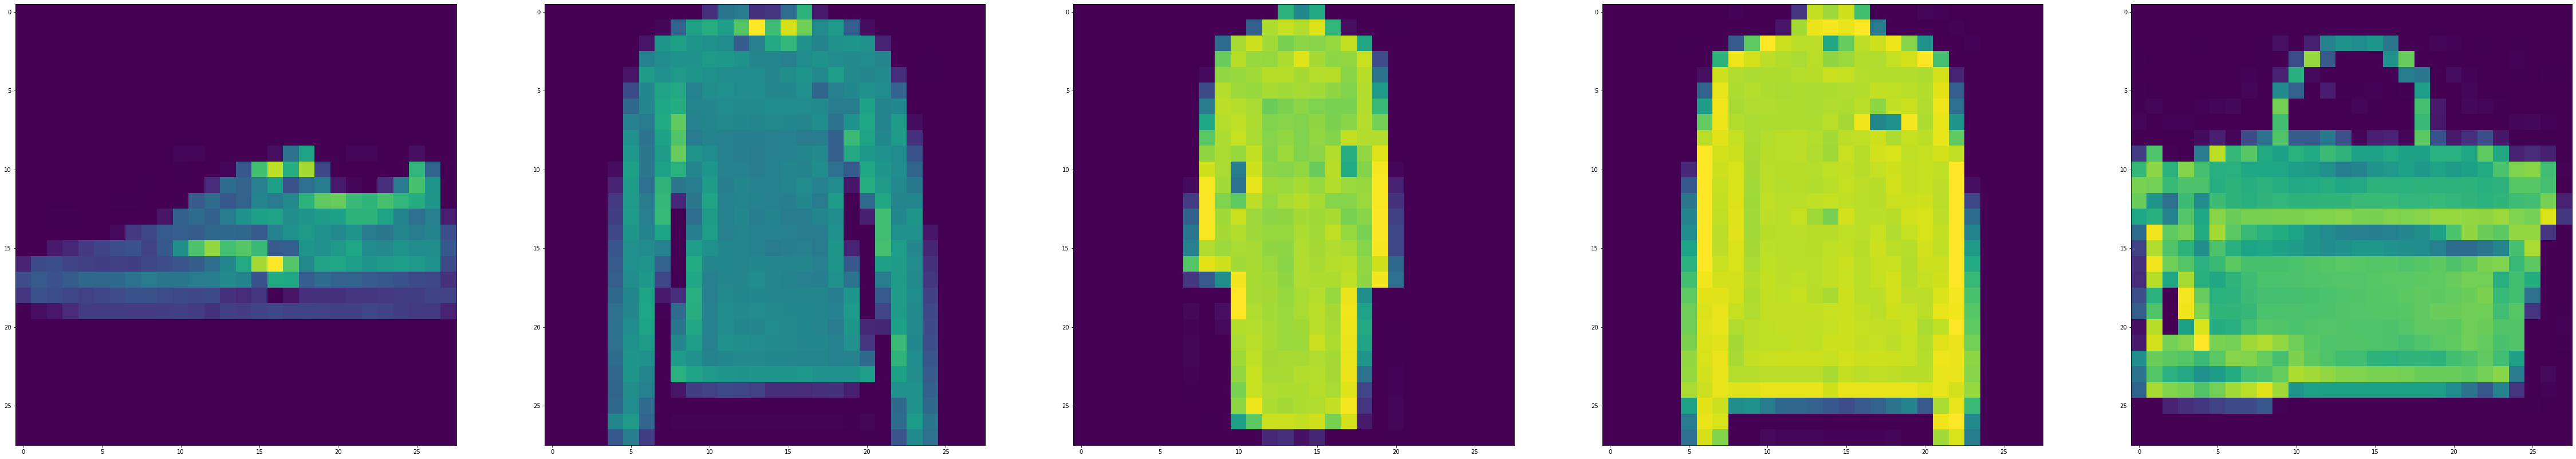

In [13]:
from PIL import Image 
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5):
    ax[i].imshow(val_x[i].reshape(28, 28))
plt.show()

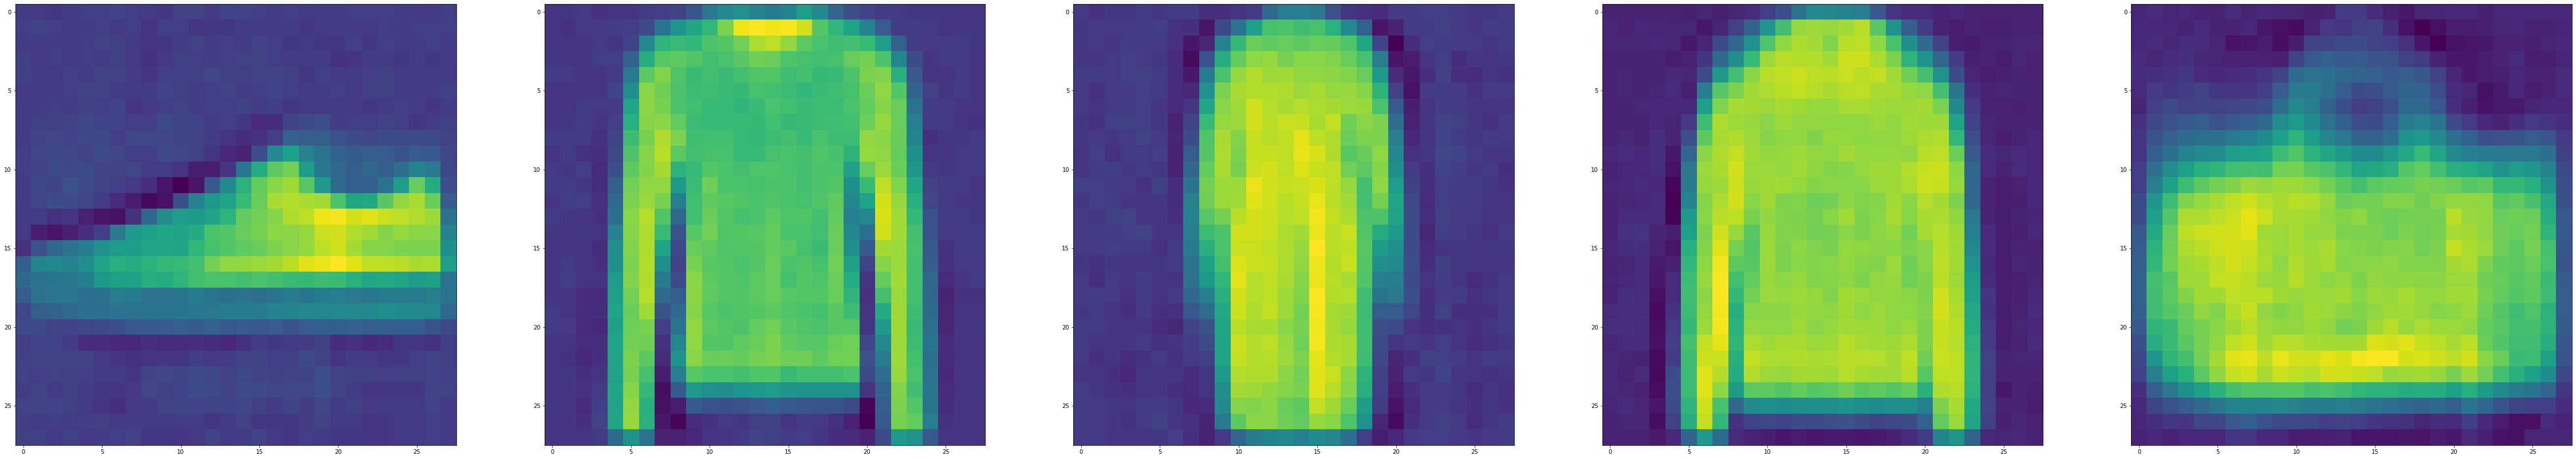

In [14]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5):
    ax[i].imshow(preds[i].reshape(28, 28))
plt.show()

# IMAGE DENOISING

In [15]:
train_x = train[list(train.columns)[1:]].values
train_x, val_x = train_test_split(train_x, test_size=0.2)

## normalize and reshape
train_x = train_x/255.
val_x = val_x/255.

In [16]:
train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)

In [18]:
noise = augmenters.SaltAndPepper(0.1)
seq_object = augmenters.Sequential([noise])

train_x_n = seq_object.augment_images(train_x * 255) / 255
val_x_n = seq_object.augment_images(val_x * 255) / 255

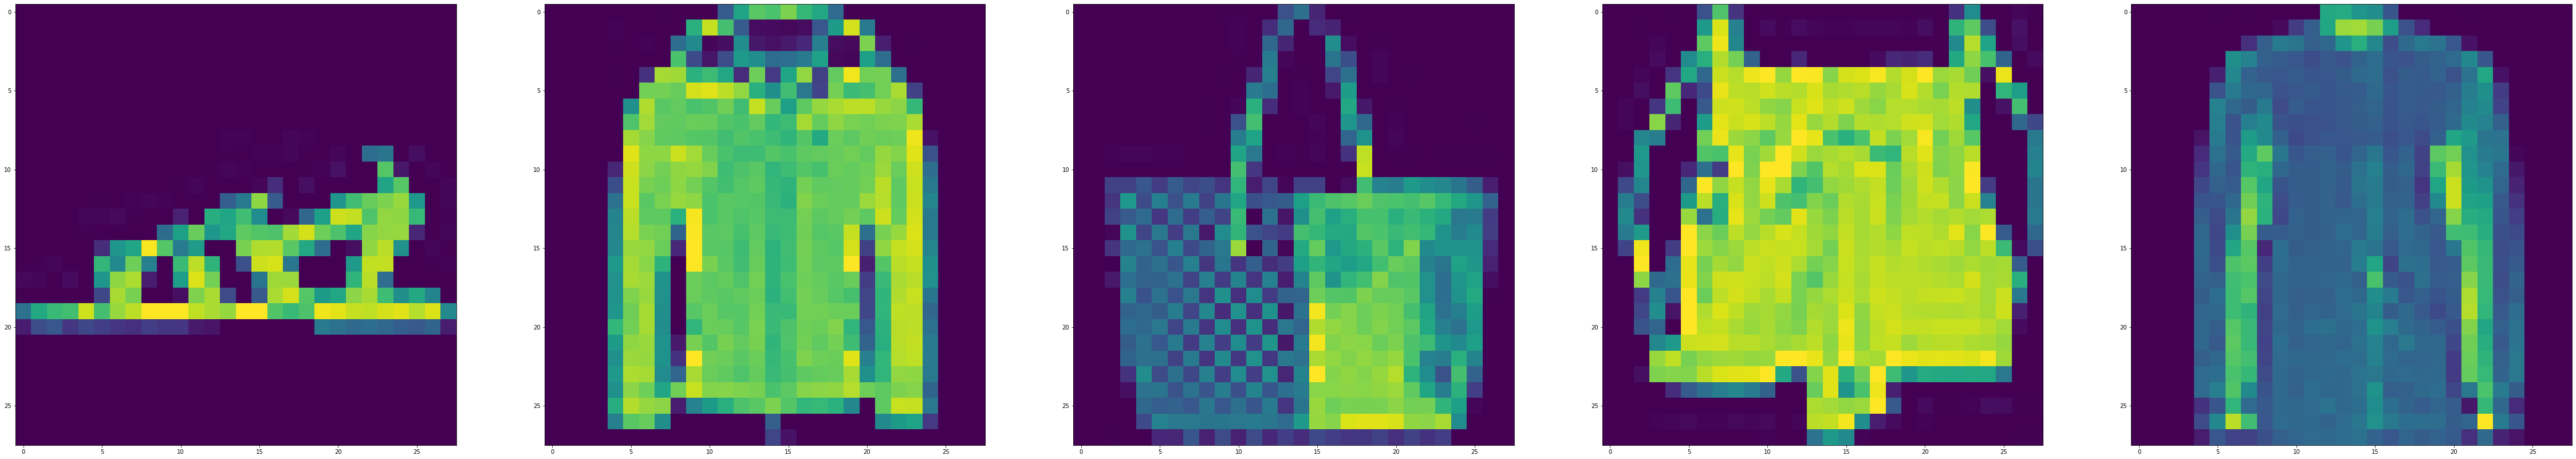

In [19]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(train_x[i].reshape(28, 28))
plt.show()

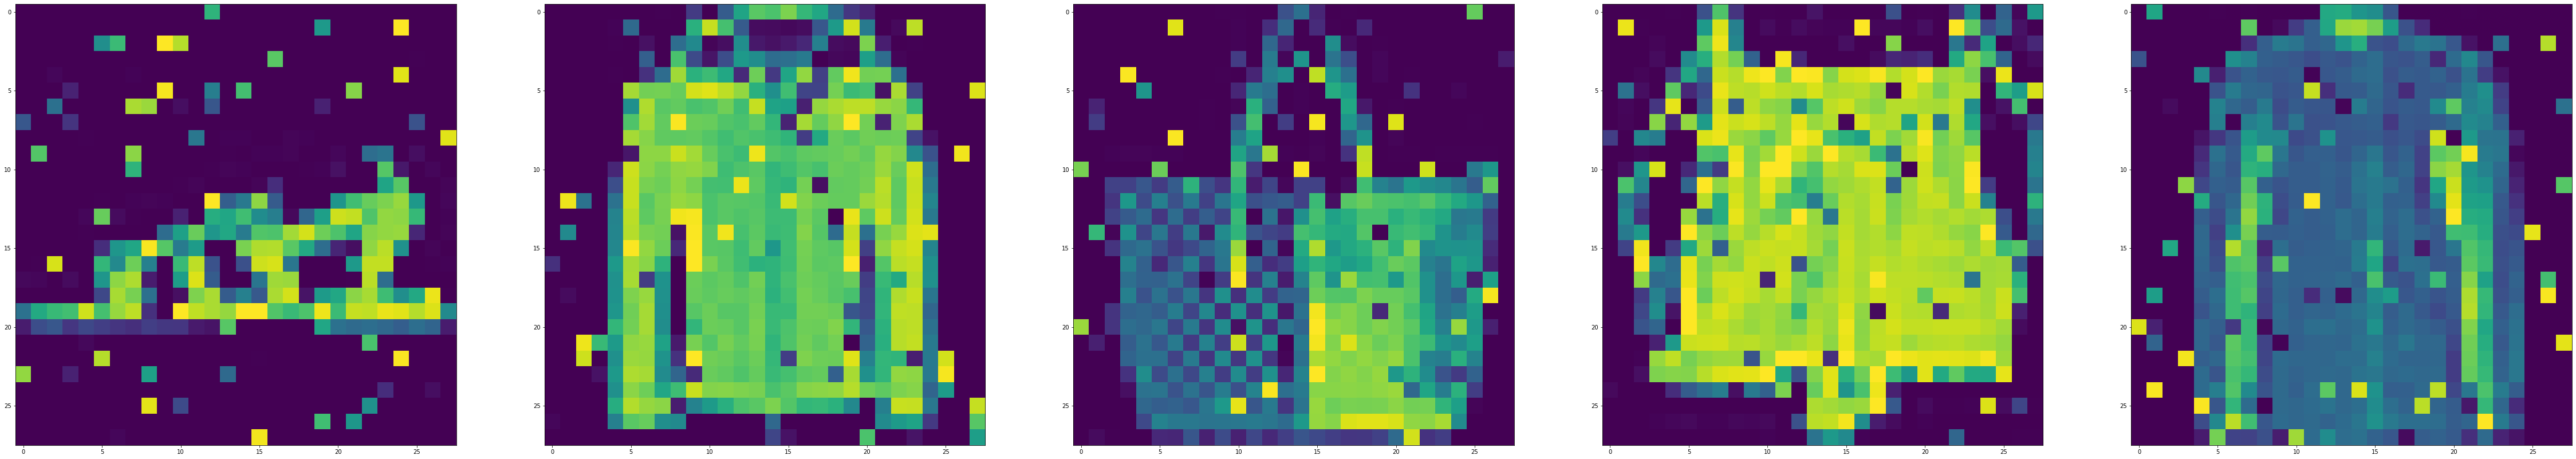

In [20]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(train_x_n[i].reshape(28, 28))
plt.show()

In [21]:
# input layer
input_layer = Input(shape=(28, 28, 1))

# encoding architecture
encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)
encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPool2D( (2, 2), padding='same')(encoded_layer2)
encoded_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)
latent_view    = MaxPool2D( (2, 2), padding='same')(encoded_layer3)

# decoding architecture
decoded_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)
output_layer   = Conv2D(1, (3, 3), padding='same')(decoded_layer3)

# compile the model
model_2 = Model(input_layer, output_layer)
model_2.compile(optimizer='adam', loss='mse')

In [22]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 16)          4624

In [23]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')
history = model_2.fit(train_x_n, train_x, epochs=10, batch_size=2048, validation_data=(val_x_n, val_x), callbacks=[early_stopping])

Epoch 1/10
24/24 [==============================] - 71s 3s/step - loss: 0.1155 - val_loss: 0.0631
Epoch 2/10
24/24 [==============================] - 67s 3s/step - loss: 0.0500 - val_loss: 0.0404
Epoch 3/10
24/24 [==============================] - 71s 3s/step - loss: 0.0372 - val_loss: 0.0342
Epoch 4/10
24/24 [==============================] - 69s 3s/step - loss: 0.0318 - val_loss: 0.0291
Epoch 5/10
24/24 [==============================] - 67s 3s/step - loss: 0.0274 - val_loss: 0.0257
Epoch 6/10
24/24 [==============================] - 71s 3s/step - loss: 0.0247 - val_loss: 0.0235
Epoch 7/10
24/24 [==============================] - 86s 4s/step - loss: 0.0230 - val_loss: 0.0222
Epoch 8/10
24/24 [==============================] - 75s 3s/step - loss: 0.0219 - val_loss: 0.0215
Epoch 9/10
24/24 [==============================] - 68s 3s/step - loss: 0.0211 - val_loss: 0.0206
Epoch 10/10
24/24 [==============================] - 68s 3s/step - loss: 0.0203 - val_loss: 0.0199


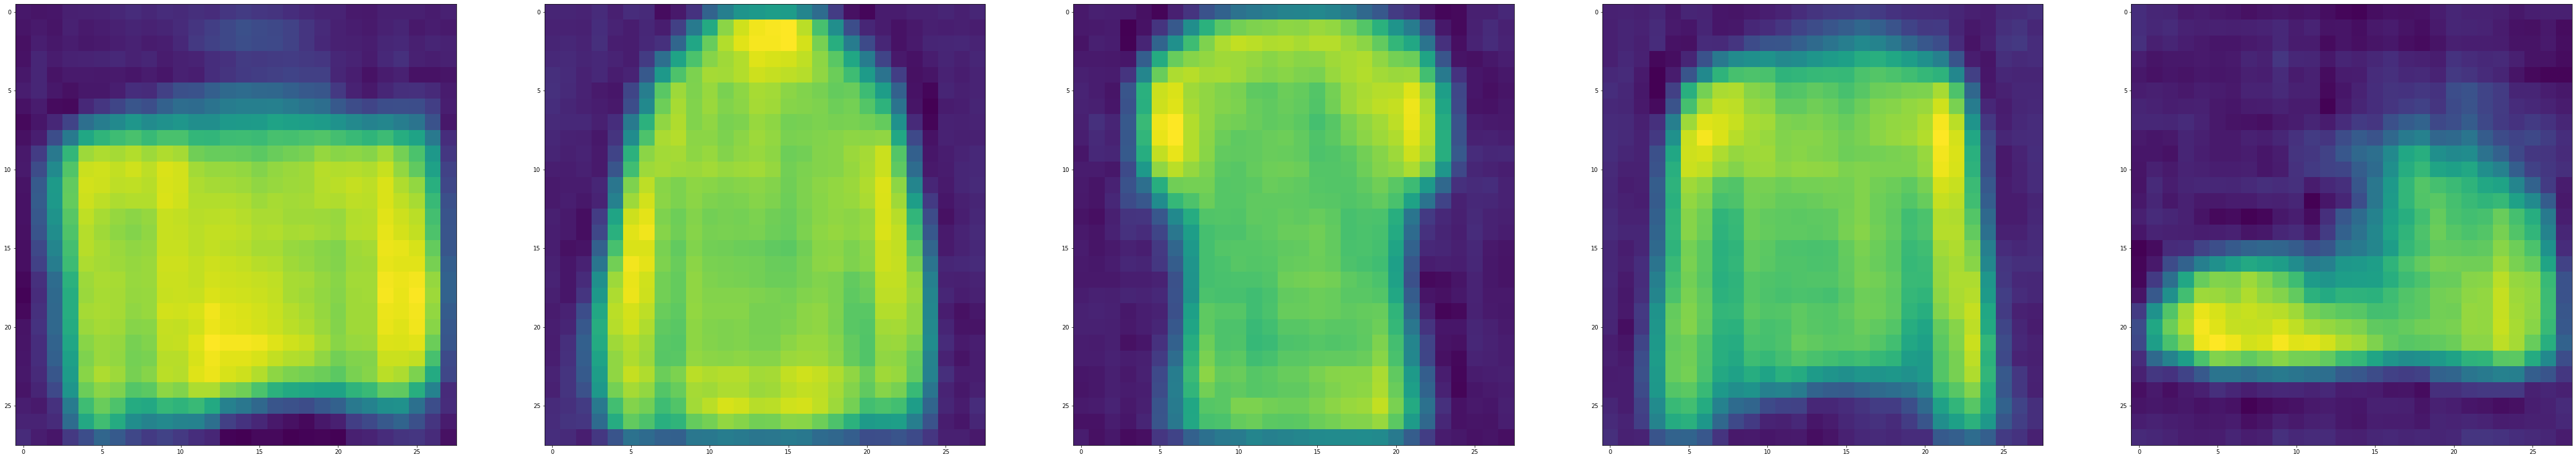

In [24]:
preds = model_2.predict(val_x_n[:10])
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(preds[i].reshape(28, 28))
plt.show()